## Final Project (2.2) Malware classification with the Cuckoo sandbox
Made by: Marco Serenelli, Damiano Pasquini

# Libraries

In [122]:
import pandas as pd
import json
from json import JSONDecodeError
import os
from sklearn.model_selection import train_test_split

In [123]:
# Ignore pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Create the dataset
Extraction of the data from the Cuckoo Sandbox report.json

In [124]:
# Read the json files and put them in a dataframe
DEFAULT_PATH = './analyses/'
REPORT_PATH = '/reports/report.json'

In [125]:
def extract_features(json_data):
    temp_row = pd.DataFrame(columns=['MD5', 'file_size', 'file_name', 'file_type', 'pe_imphash', 'path_pe_section_entropy'])
    '''
        Target
        - File size (static)
        - File name (static)
        - File type (static)
        - File MD5 (static)
    '''
    try:
        temp_row.at[0, 'file_size'] = json_data['target']['file']['size']
        temp_row.at[0, 'file_name'] = json_data['target']['file']['name']
        temp_row.at[0, 'file_type'] = json_data['target']['file']['type']
        temp_row.at[0, 'MD5'] = json_data['target']['file']['md5']
    except KeyError:
        pass

    '''
        Static
        - Imported DLL (sequence)
        - Hash of the imported DLLs (static)
    '''
    try:
        for imported_dll in json_data['static']['pe_imports']:
            temp_row[imported_dll['dll']] = 1
        temp_row.at[0, 'pe_imphash'] = json_data['static']['pe_imphash']

        entropy_sum = 0
        for entropy_val in json_data['static']['pe_sections']:
            entropy_sum += entropy_val['entropy']
        temp_row.at[0, 'path_pe_section_entropy'] = entropy_sum / len(json_data['static']['pe_sections'])
    except KeyError:
        pass

    '''
        Signatures
        - Signatures names (sequence)
    '''
    try:
        temp_row.at[0, 'signatures_number'] = len(json_data['signatures'])
    except KeyError:
        pass

    '''
        Behavior
        - Files Created (sequence)
        - Files Written (sequence)
        - Regkeys Opened (sequence)
        - Regkeys Written (sequence)
        - Regkeys Read (sequence)
        - Generic process (sequence)
    }
    '''
    # TODO; Maybe first seen pattern?
    try:
        temp_row.at[0, 'generic_process_number'] = len(json_data['behavior']['generic'])
        temp_row.at[0, 'file_created_number'] = len(json_data['behavior']['summary']['file_created'])
        temp_row.at[0, 'file_written_number'] = len(json_data['behavior']['summary']['file_written'])
        temp_row.at[0, 'regkey_opened_number'] = len(json_data['behavior']['summary']['regkey_opened'])
        temp_row.at[0, 'regkey_written_number'] = len(json_data['behavior']['summary']['regkey_written'])
        temp_row.at[0, 'regkey_read_number'] = len(json_data['behavior']['summary']['regkey_read'])
    except KeyError:
        pass

    try:
        # Calculate average difference between each seen
        first_seen_values = [entry['first_seen'] for entry in json_data['behavior']['generic']]
        absolute_differences = [abs(second - first) for first, second in zip(first_seen_values, first_seen_values[1:])]
        if len(absolute_differences) > 0:
            average_absolute_difference = sum(absolute_differences) / len(absolute_differences)
            temp_row.at[0, 'average_difference'] = average_absolute_difference
        else:
            temp_row.at[0, 'average_difference'] = 0
    except KeyError:
        pass
    return temp_row

def add_labels(df):
    df_labels = pd.read_csv('data/final.csv')
    return df.merge(df_labels[['MD5', 'label']], on='MD5', how='left')
    
def populate_dataset(df):
    # Look for all the json and extract dynamic features
    for _ , path_file in enumerate(sorted(os.listdir(DEFAULT_PATH), key=int)):
        with open(DEFAULT_PATH + path_file + REPORT_PATH) as json_file:
            try:
                row = extract_features(json.load(json_file))
                # Append the new row to the DataFrame
                df = pd.concat([df, row], ignore_index=True)                
            except JSONDecodeError:
                print("Error in file: " + json_file.name)
                continue
    
    df = add_labels(df)
    # Fill NaN with 0
    df = df.fillna(0)
    # Save the dataset
    if not os.path.exists('data'):
        os.makedirs('data')
    df.to_csv('data/dataset.csv', index=False)

def create_dataset():
    # Create the dataframe with static columns
    df = pd.DataFrame(columns=['MD5', 'file_size', 'file_name', 'file_type', 'pe_imphash'])
    populate_dataset(df)
    return df

In [126]:
dataset = create_dataset()

Error in file: ./analyses/49/reports/report.json
Error in file: ./analyses/52/reports/report.json
Error in file: ./analyses/65/reports/report.json
Error in file: ./analyses/68/reports/report.json
Error in file: ./analyses/73/reports/report.json
Error in file: ./analyses/85/reports/report.json
Error in file: ./analyses/107/reports/report.json
Error in file: ./analyses/147/reports/report.json
Error in file: ./analyses/207/reports/report.json
Error in file: ./analyses/296/reports/report.json
Error in file: ./analyses/302/reports/report.json
Error in file: ./analyses/663/reports/report.json
Error in file: ./analyses/696/reports/report.json
Error in file: ./analyses/701/reports/report.json
Error in file: ./analyses/702/reports/report.json
Error in file: ./analyses/705/reports/report.json
Error in file: ./analyses/716/reports/report.json
Error in file: ./analyses/732/reports/report.json
Error in file: ./analyses/759/reports/report.json
Error in file: ./analyses/774/reports/report.json
Error 

In [127]:
def one_hot_encoding(df):
    categorical_columns = ['file_name', 'file_type', 'pe_imphash', 'file_size', 'MD5']
    df_encoded = pd.get_dummies(df, columns=categorical_columns)
    df_encoded.to_csv('data/dataset_encoded.csv', index=False)
    return df_encoded

def remove_minority_classes(df):
    df = df[df.label != 'adware']
    df = df[df.label != 'hacktool']
    df = df[df.label != 'banker']
    df = df[df.label != 'phishing']
    return df

def scale_features(X_train, X_test):
    # Scale features
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Plotting Utilities

In [128]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Plot dataset to check for imbalanced classes
def plot_dataset(df, title):
    class_distribution = df['label'].value_counts()
    print(class_distribution)
    plt.figure(figsize=(8, 6))
    plt.bar(class_distribution.index, class_distribution.values)
    plt.title('Class Distribution of ' + title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45)
    if not os.path.exists("results/class_distribution"):
        os.makedirs("results/class_distribution")
    plt.savefig('results/class_distribution/'+ title + '.png')
    plt.show()

def plot_confusion_matrix(exp, pred, classifier_name, feature_names):
    cm = confusion_matrix(exp, pred, labels=feature_names)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=feature_names, yticklabels=feature_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {classifier_name}')
    plt.tight_layout()
    
    if not os.path.exists("results/confusion_matrix"):
        os.makedirs("results/confusion_matrix")
    plt.savefig('results/confusion_matrix/'+ classifier_name +'.png')
    plt.show()

def plot_multiclass_roc(test_label, y_pred, classifier_name):
    # Binarize the labels for multiclass ROC
    classes = list(set(test_label))
    y_test_bin = label_binarize(test_label, classes=classes)
    y_pred_bin = label_binarize(y_pred, classes=classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lime', 'purple', 'red', 'yellow', 'pink', 'brown', 'grey'])
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(classifier_name + ' ROC Curve')
    plt.legend(loc="lower right")
    if not os.path.exists("results/ROC"):
        os.makedirs("results/ROC")
    plt.savefig('results/ROC/'+ classifier_name +'.png')
    plt.show()

# Create ML models

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np

In [130]:
# All classifiers
classifier_functions = {
    "naive_bayes": MultinomialNB,
    "knn": KNeighborsClassifier,
    "logistic_regression": lambda: LogisticRegression(max_iter=1000),
    "svm": lambda: SVC(kernel='linear'),
    "random_forest": RandomForestClassifier,
    "decision_tree": DecisionTreeClassifier
}

In [131]:
DATASET_PATH = 'data/dataset.csv'
def load_data():
    df = pd.read_csv(DATASET_PATH)
    plot_dataset(df, 'Dataset_complete')
    df = remove_minority_classes(df)
    plot_dataset(df, 'Dataset_trimmed')
    # one hot encode categorical data
    df = one_hot_encoding(df)
    # encode y
    df.to_csv('data/dataset_encoded.csv', index=False)
    # Take the y
    y = df['label']
    # Take the X
    X = df.drop(['label'], axis=1)
    # divide train (70%), test (30%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # scale
    X_train, X_test = scale_features(X_train, X_test)
    return X_train, X_test, y_train, y_test

label
Benign        1000
fakeav         551
trojan         358
Unknown        162
ransomware      54
worm            54
dropper         48
spyware         45
virus           27
downloader      18
pua             15
hacktool         5
adware           3
banker           1
phishing         1
Name: count, dtype: int64


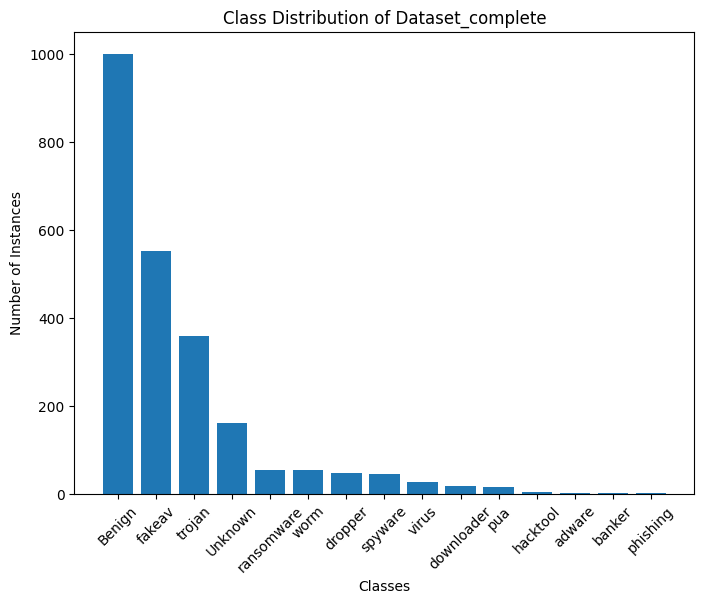

label
Benign        1000
fakeav         551
trojan         358
Unknown        162
ransomware      54
worm            54
dropper         48
spyware         45
virus           27
downloader      18
pua             15
Name: count, dtype: int64


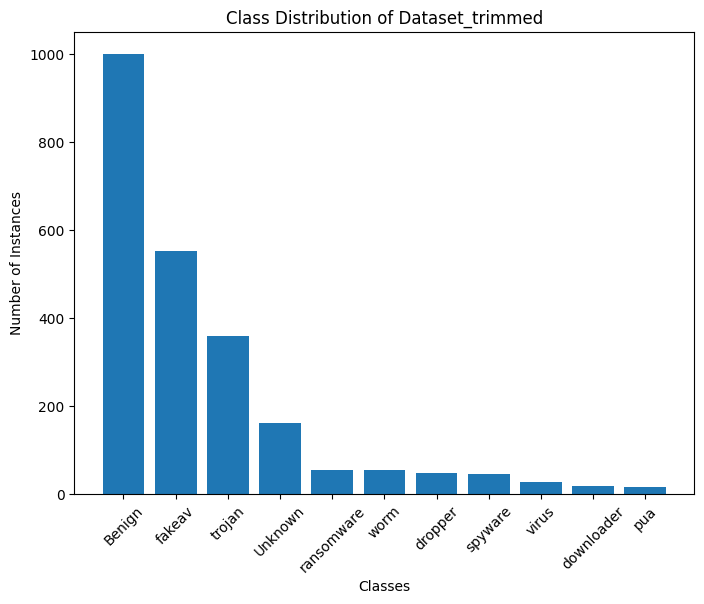

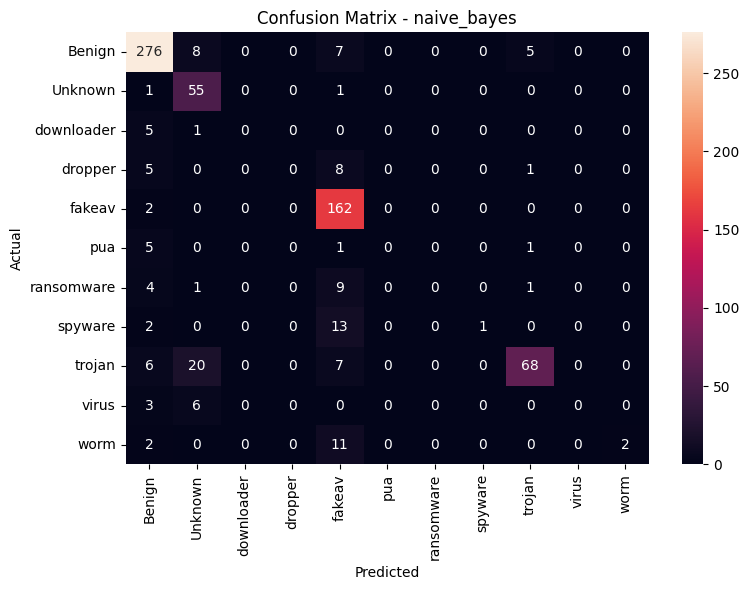

F1 Score macro average: 0.3290808590051132


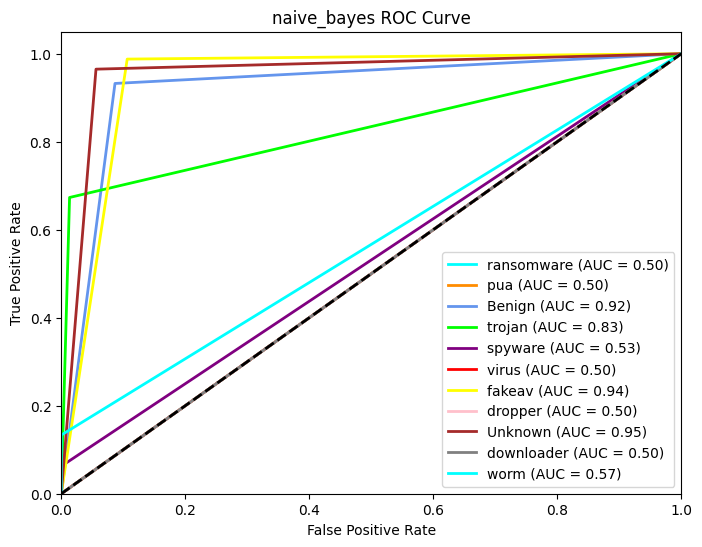

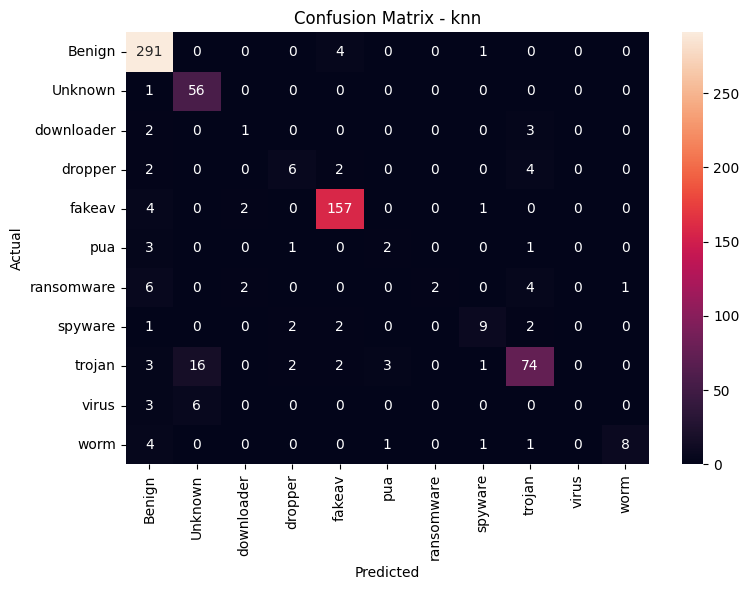

F1 Score macro average: 0.5449257822941993


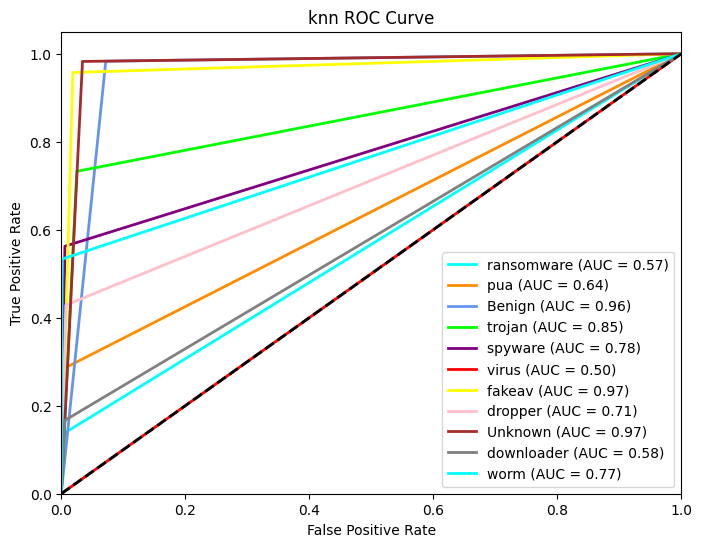

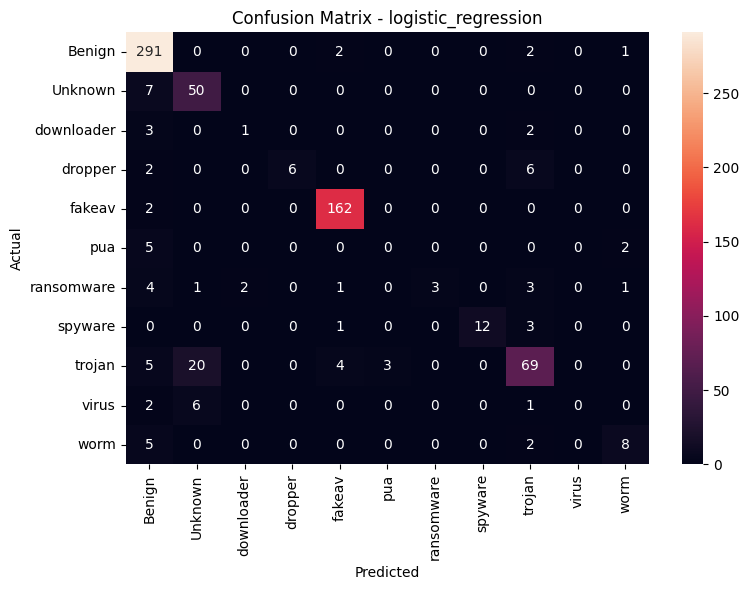

F1 Score macro average: 0.5443154173394226


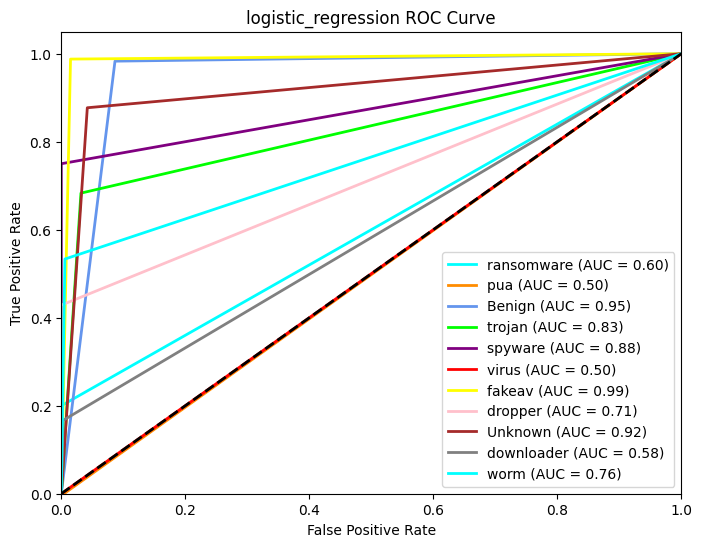

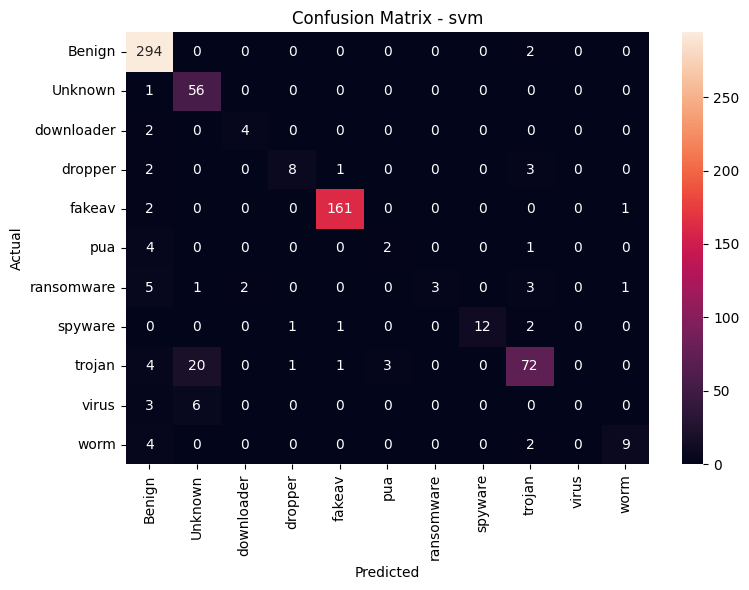

F1 Score macro average: 0.641668163105934


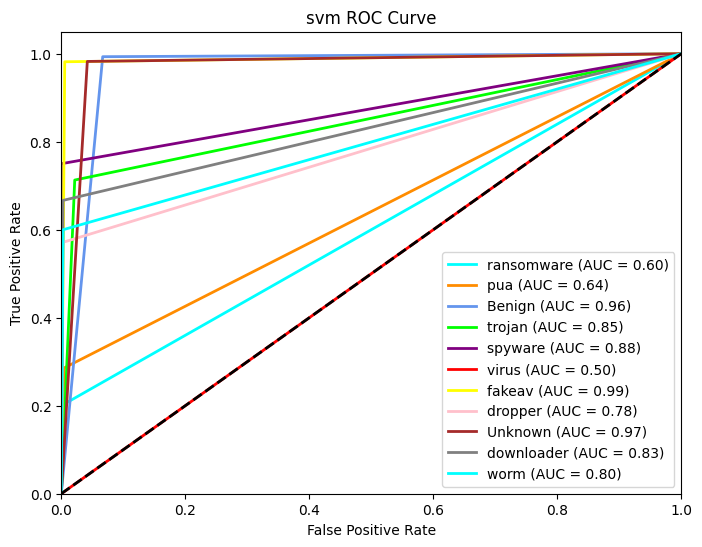

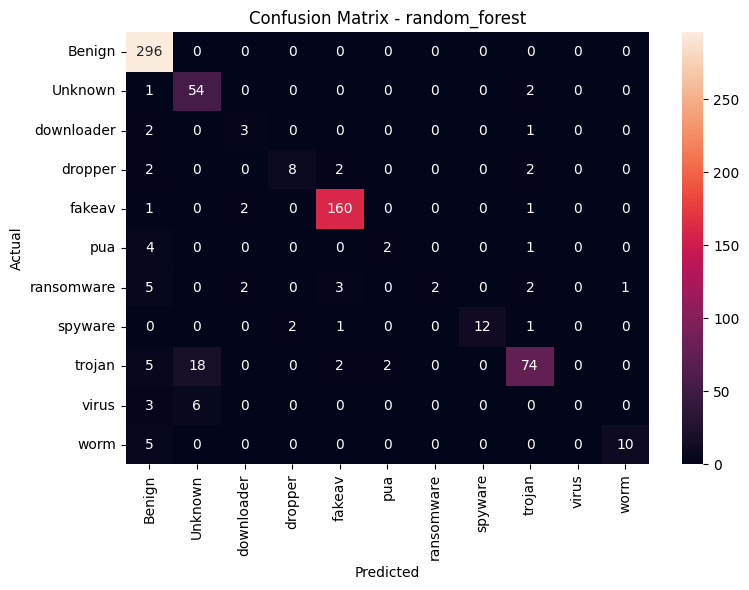

F1 Score macro average: 0.6247457606569402


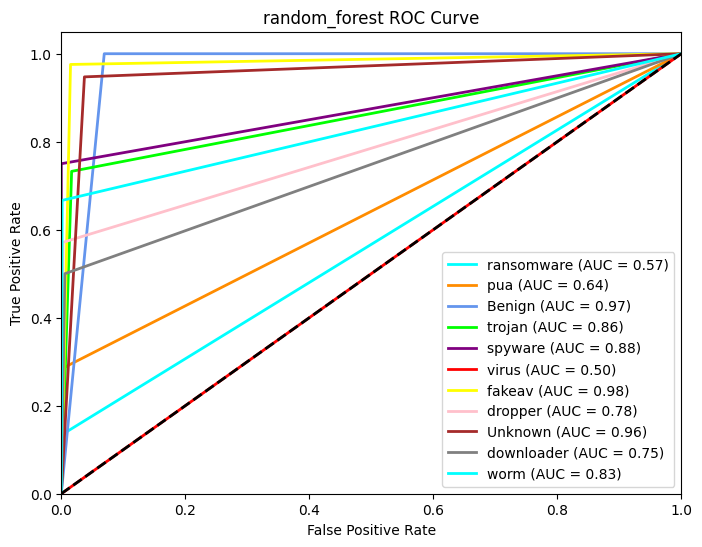

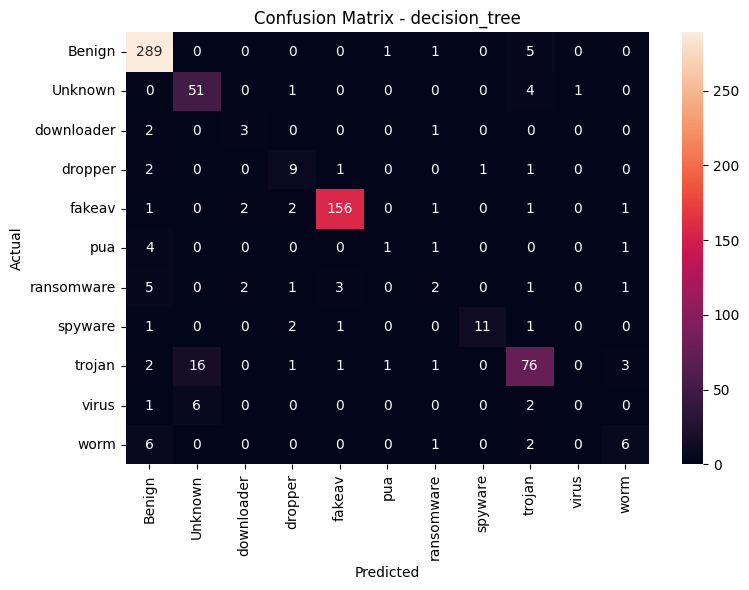

F1 Score macro average: 0.5581711699350275


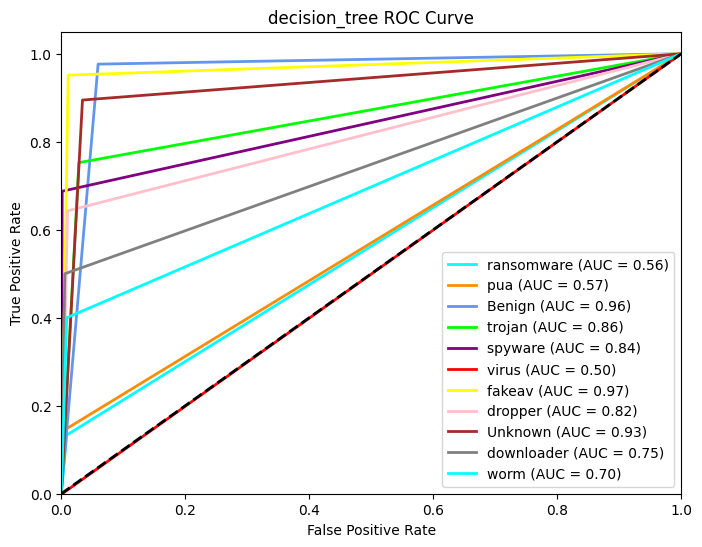

Best classifier is svm with scaling: False and F1 0.641668163105934


In [132]:
def train_classifier(train_data, train_label, test_data, test_label, classifier, classifier_name, feature_names):
    classifier.fit(train_data, train_label)
    # Predict the labels of the test set
    y_pred = classifier.predict(test_data)
    plot_confusion_matrix(test_label, y_pred, classifier_name, feature_names)
    score = f1_score(test_label, y_pred, average='macro')
    print(f'F1 Score macro average: {score}')
    # Plot ROC
    plot_multiclass_roc(test_label, y_pred, classifier_name)
    return classifier, score

# Find the best score among all
def find_best_score(train_data, train_label, test_data, test_label, feature_names, cl = None, cl_name = None, cl_f1 = 0):
    score = 0
    best_f1 = cl_f1
    best_classifier_name = cl_name
    best_classifier = cl
    is_best_scaled = False
    for classifier_name in classifier_functions:
        classifier_ret, score = train_classifier(train_data, train_label, test_data, test_label, classifier_functions[classifier_name](), classifier_name, feature_names)
        if score > best_f1:
            best_f1 = score
            best_classifier = classifier_ret
            best_classifier_name = classifier_name
    return best_classifier, best_classifier_name, best_f1, is_best_scaled

# Find the best classifier 
def find_best_classifier():
    x_train, x_test, y_train, y_test = load_data()
    feature_names = np.unique(y_train)
    cl, cl_name, cl_f1, scaled = find_best_score(x_train, y_train, x_test, y_test, feature_names)
    print(f"Best classifier is {cl_name} with scaling: {scaled} and F1 {cl_f1}")
    return cl, cl_name, cl_f1

classifier, classifier_name, classifier_f1 = find_best_classifier()